# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 64
fuzzification_kernel_size = 16
enrich_lemmas_with_wn = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
X_train, y_train, X_test, y_test = (
    X_train[:sample_size],
    y_train[:sample_size],
    X_train[:sample_size],  # evaluating space on training set, as training set has more samples and map is nonparametric
    y_train[:sample_size],
    # X_test[:sample_size],
    # y_test[:sample_size]
)
sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel()
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.23790538,  0.0530607 ,  0.07269605, ...,  0.07510906,
         0.00704104, -0.01477473],
       [ 0.08852166, -0.09751736, -0.22334981, ...,  0.03462375,
         0.01768318,  0.04077258],
       [ 0.1532093 ,  0.25974676, -0.20822528, ..., -0.099953  ,
        -0.05916501, -0.0457732 ],
       ...,
       [ 0.16191025,  0.12579915, -0.05918673, ..., -0.07039158,
        -0.10289208, -0.03268382],
       [ 0.27350608,  0.04741487, -0.05511393, ...,  0.12433715,
         0.15227771, -0.11344113],
       [ 0.12429294, -0.1077695 ,  0.10518754, ..., -0.04523592,
         0.10054181, -0.0388323 ]], dtype=float32)

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for baseline_sent approac

,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_mean_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_baseline_sent_wasserstein-1_sim,...,fuzzy_baseline_tok_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_mean_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,-0.145443,-0.083358,0.004786,0.010350,0.004786,-0.000247,0.005661,0.005661,0.023935,-0.067639,...,-0.057177,-0.010557,-0.009348,-0.010557,-0.145610,-0.003752,-0.003752,0.008703,-0.143688,-0.124497
1,-0.280059,0.008559,-0.000124,0.001879,-0.000124,0.030524,-0.002283,-0.002283,-0.003158,-0.078382,...,0.016150,0.000802,0.000096,0.000802,0.034049,-0.002663,-0.002663,-0.000135,-0.146585,0.040091
2,-0.162801,-0.206163,0.008531,0.004629,0.008531,-0.138546,0.006228,0.006228,-0.098868,-0.015823,...,-0.161907,-0.009435,-0.005349,-0.009435,-0.371950,-0.000082,-0.000082,-0.192339,-0.101913,-0.285893
3,-0.069404,-0.027245,-0.001690,-0.001755,-0.001690,-0.045535,-0.034849,-0.034849,-0.120007,-0.020814,...,-0.023262,0.000907,0.000569,0.000907,-0.031652,-0.003565,-0.003565,-0.036710,-0.135200,-0.025038
4,0.289966,0.034107,0.001007,0.000657,0.001007,0.180805,-0.035478,-0.035478,-0.133407,0.143770,...,0.012835,-0.001934,-0.002026,-0.001934,0.192576,-0.002757,-0.002757,-0.032427,0.376279,0.134163


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

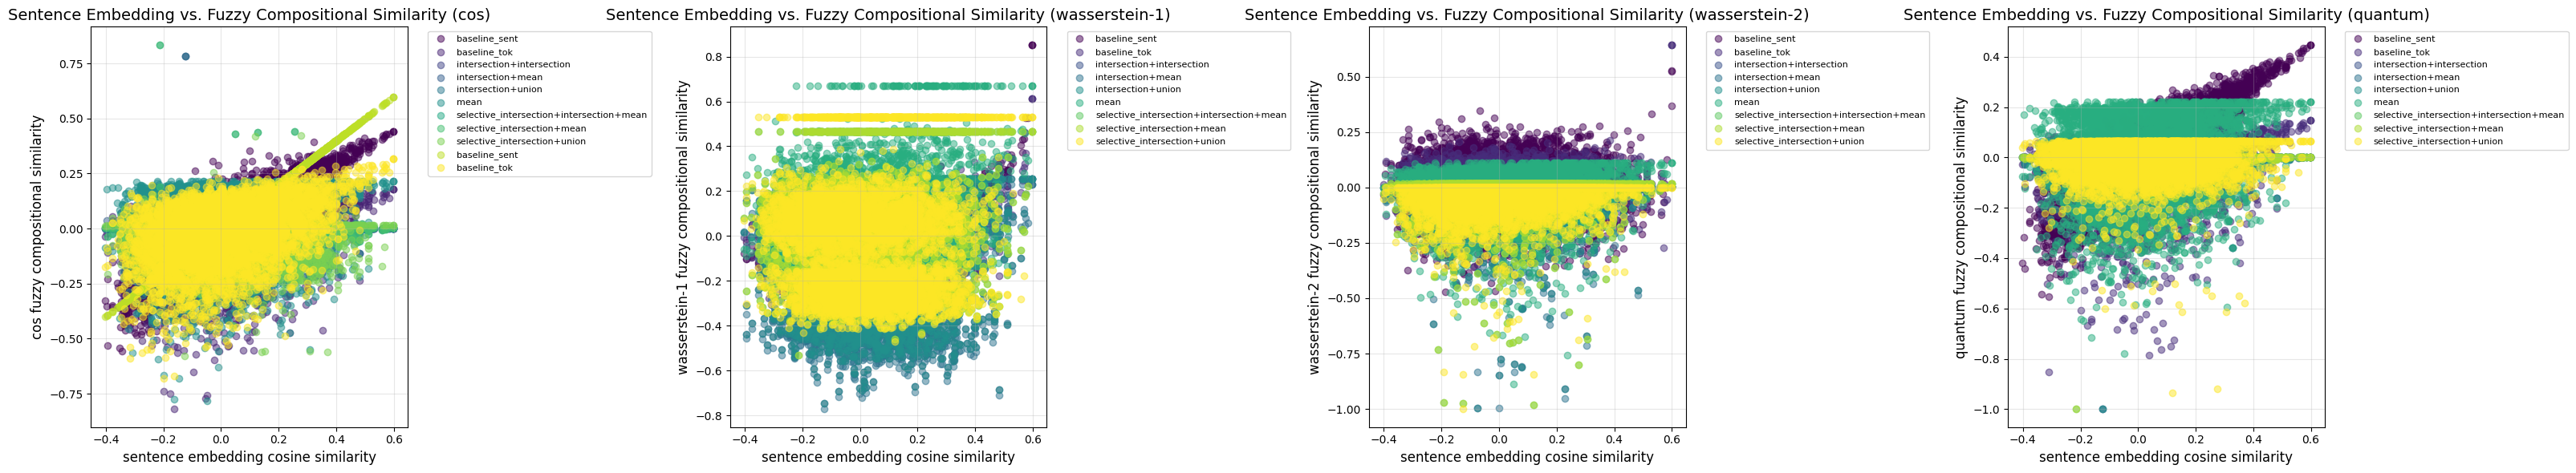

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

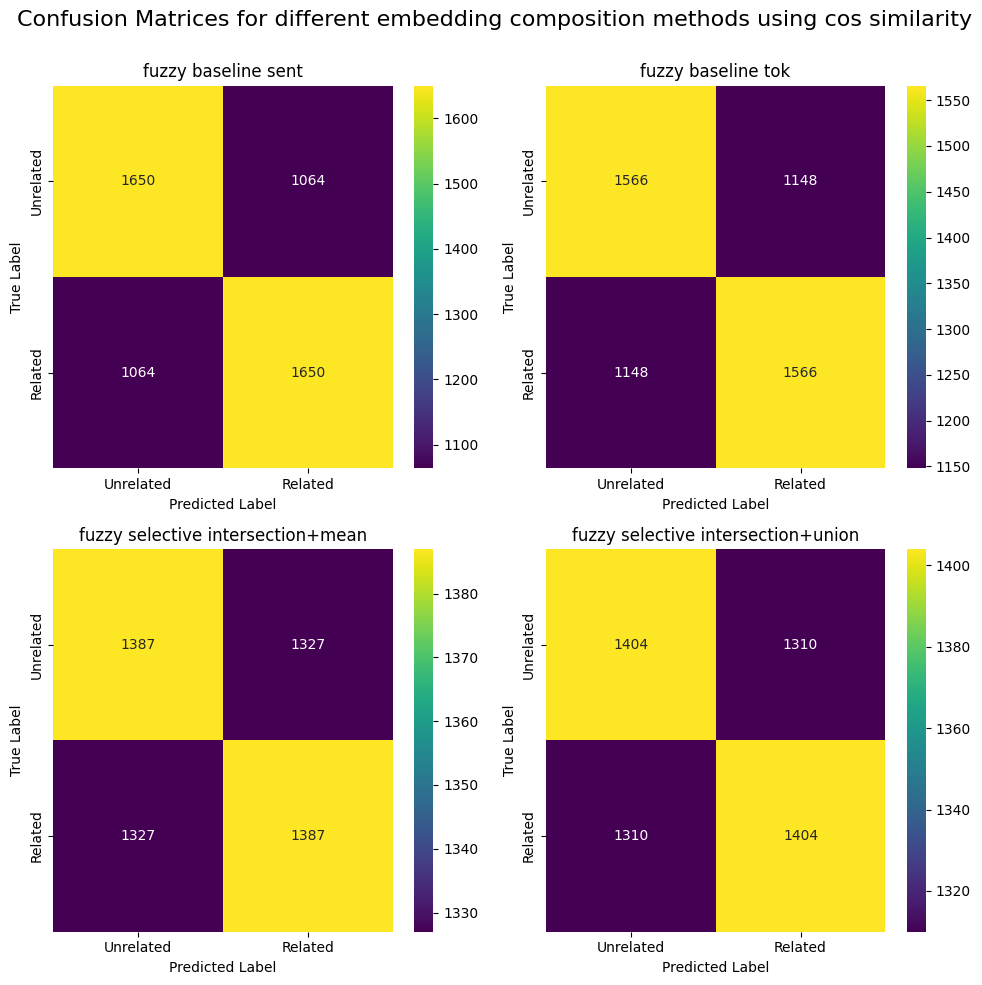

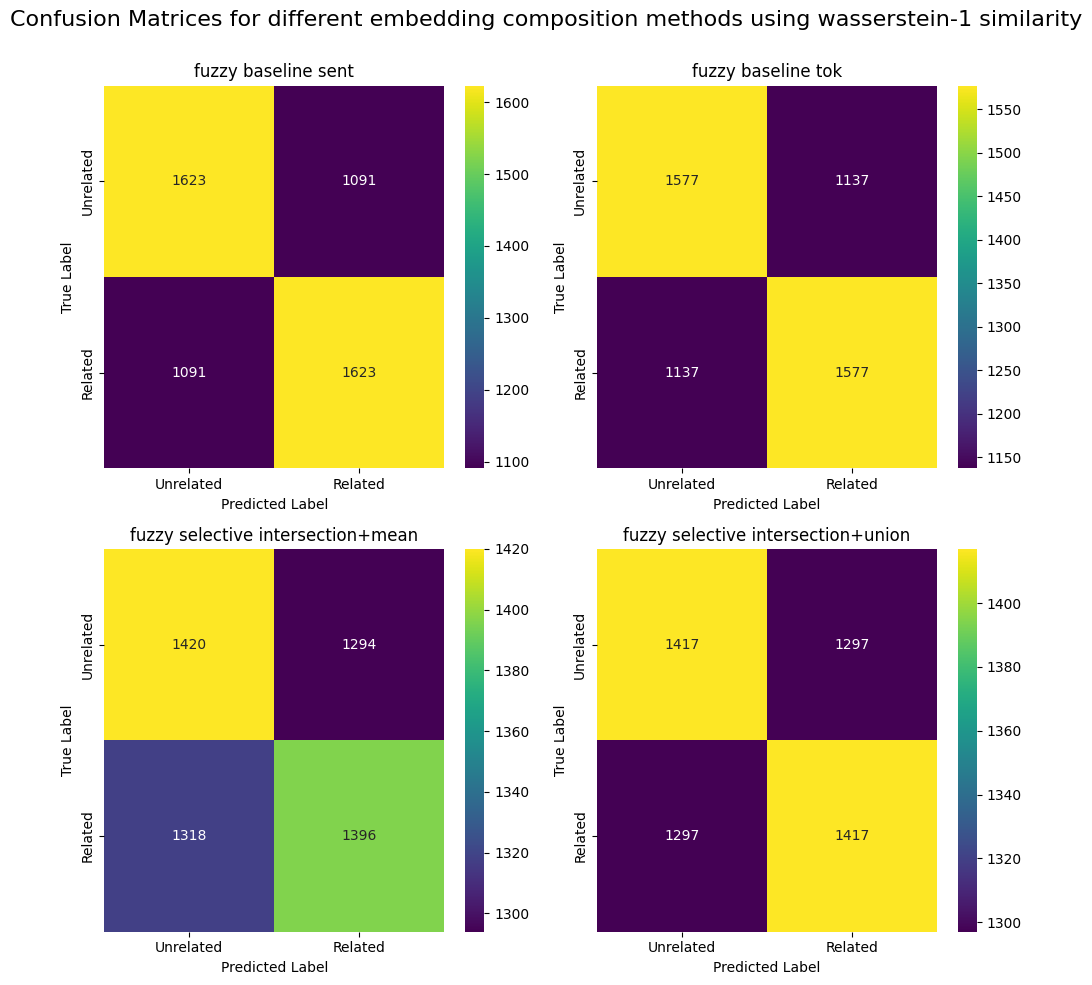

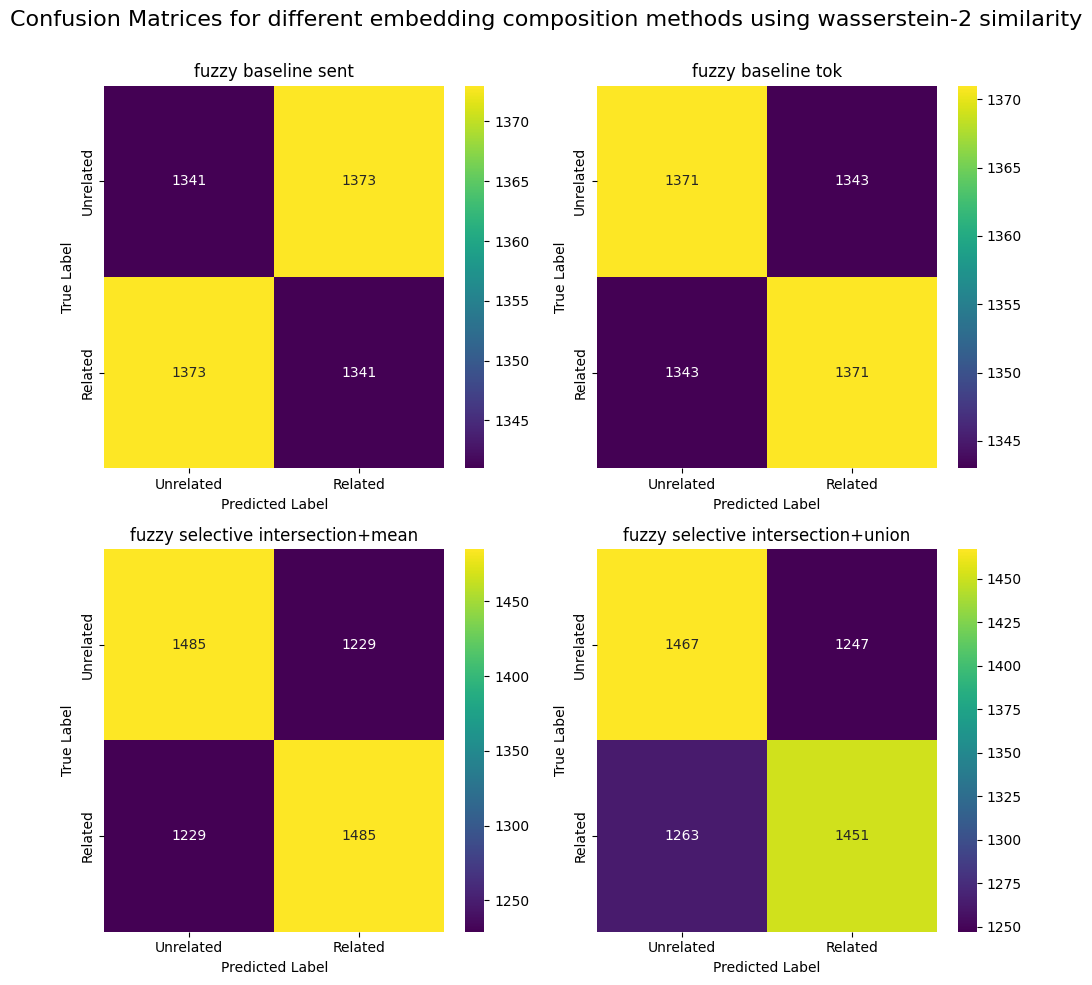

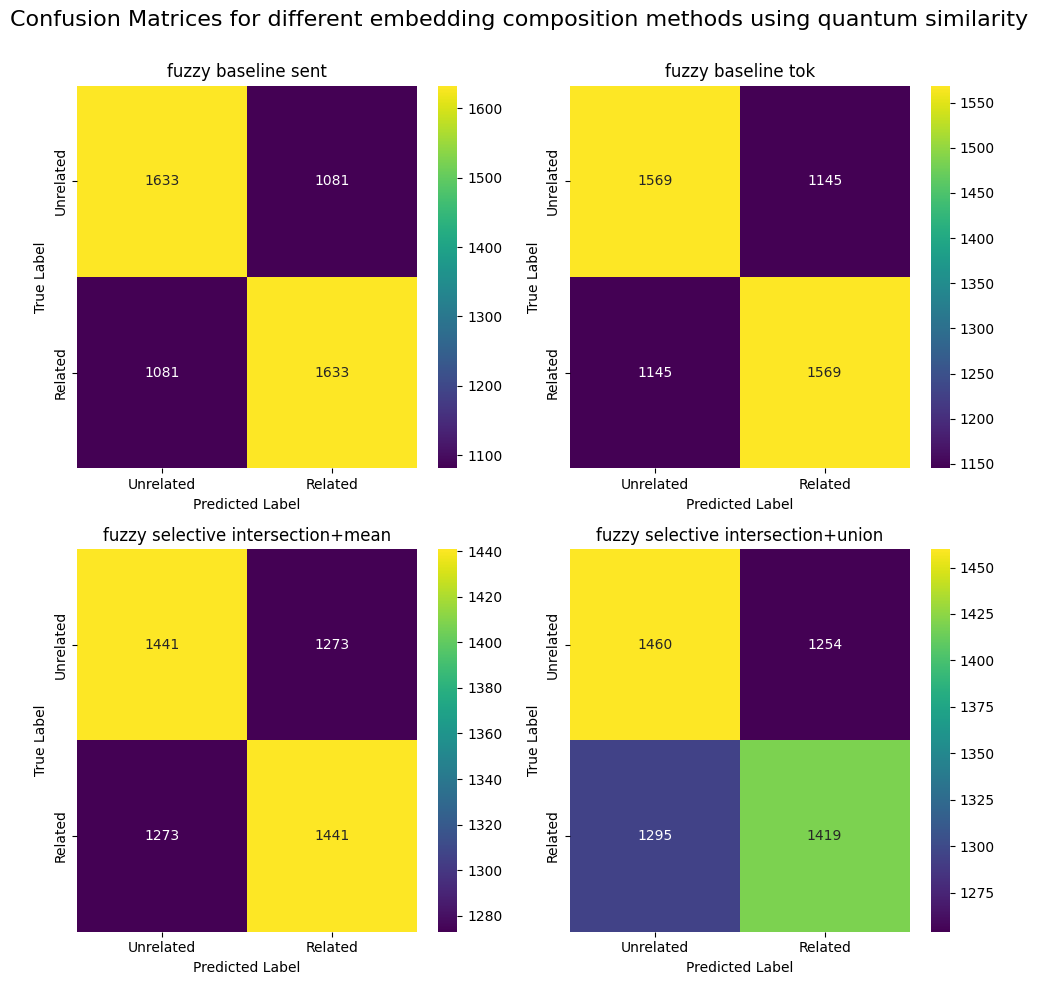

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test
)

# Evaluation Results

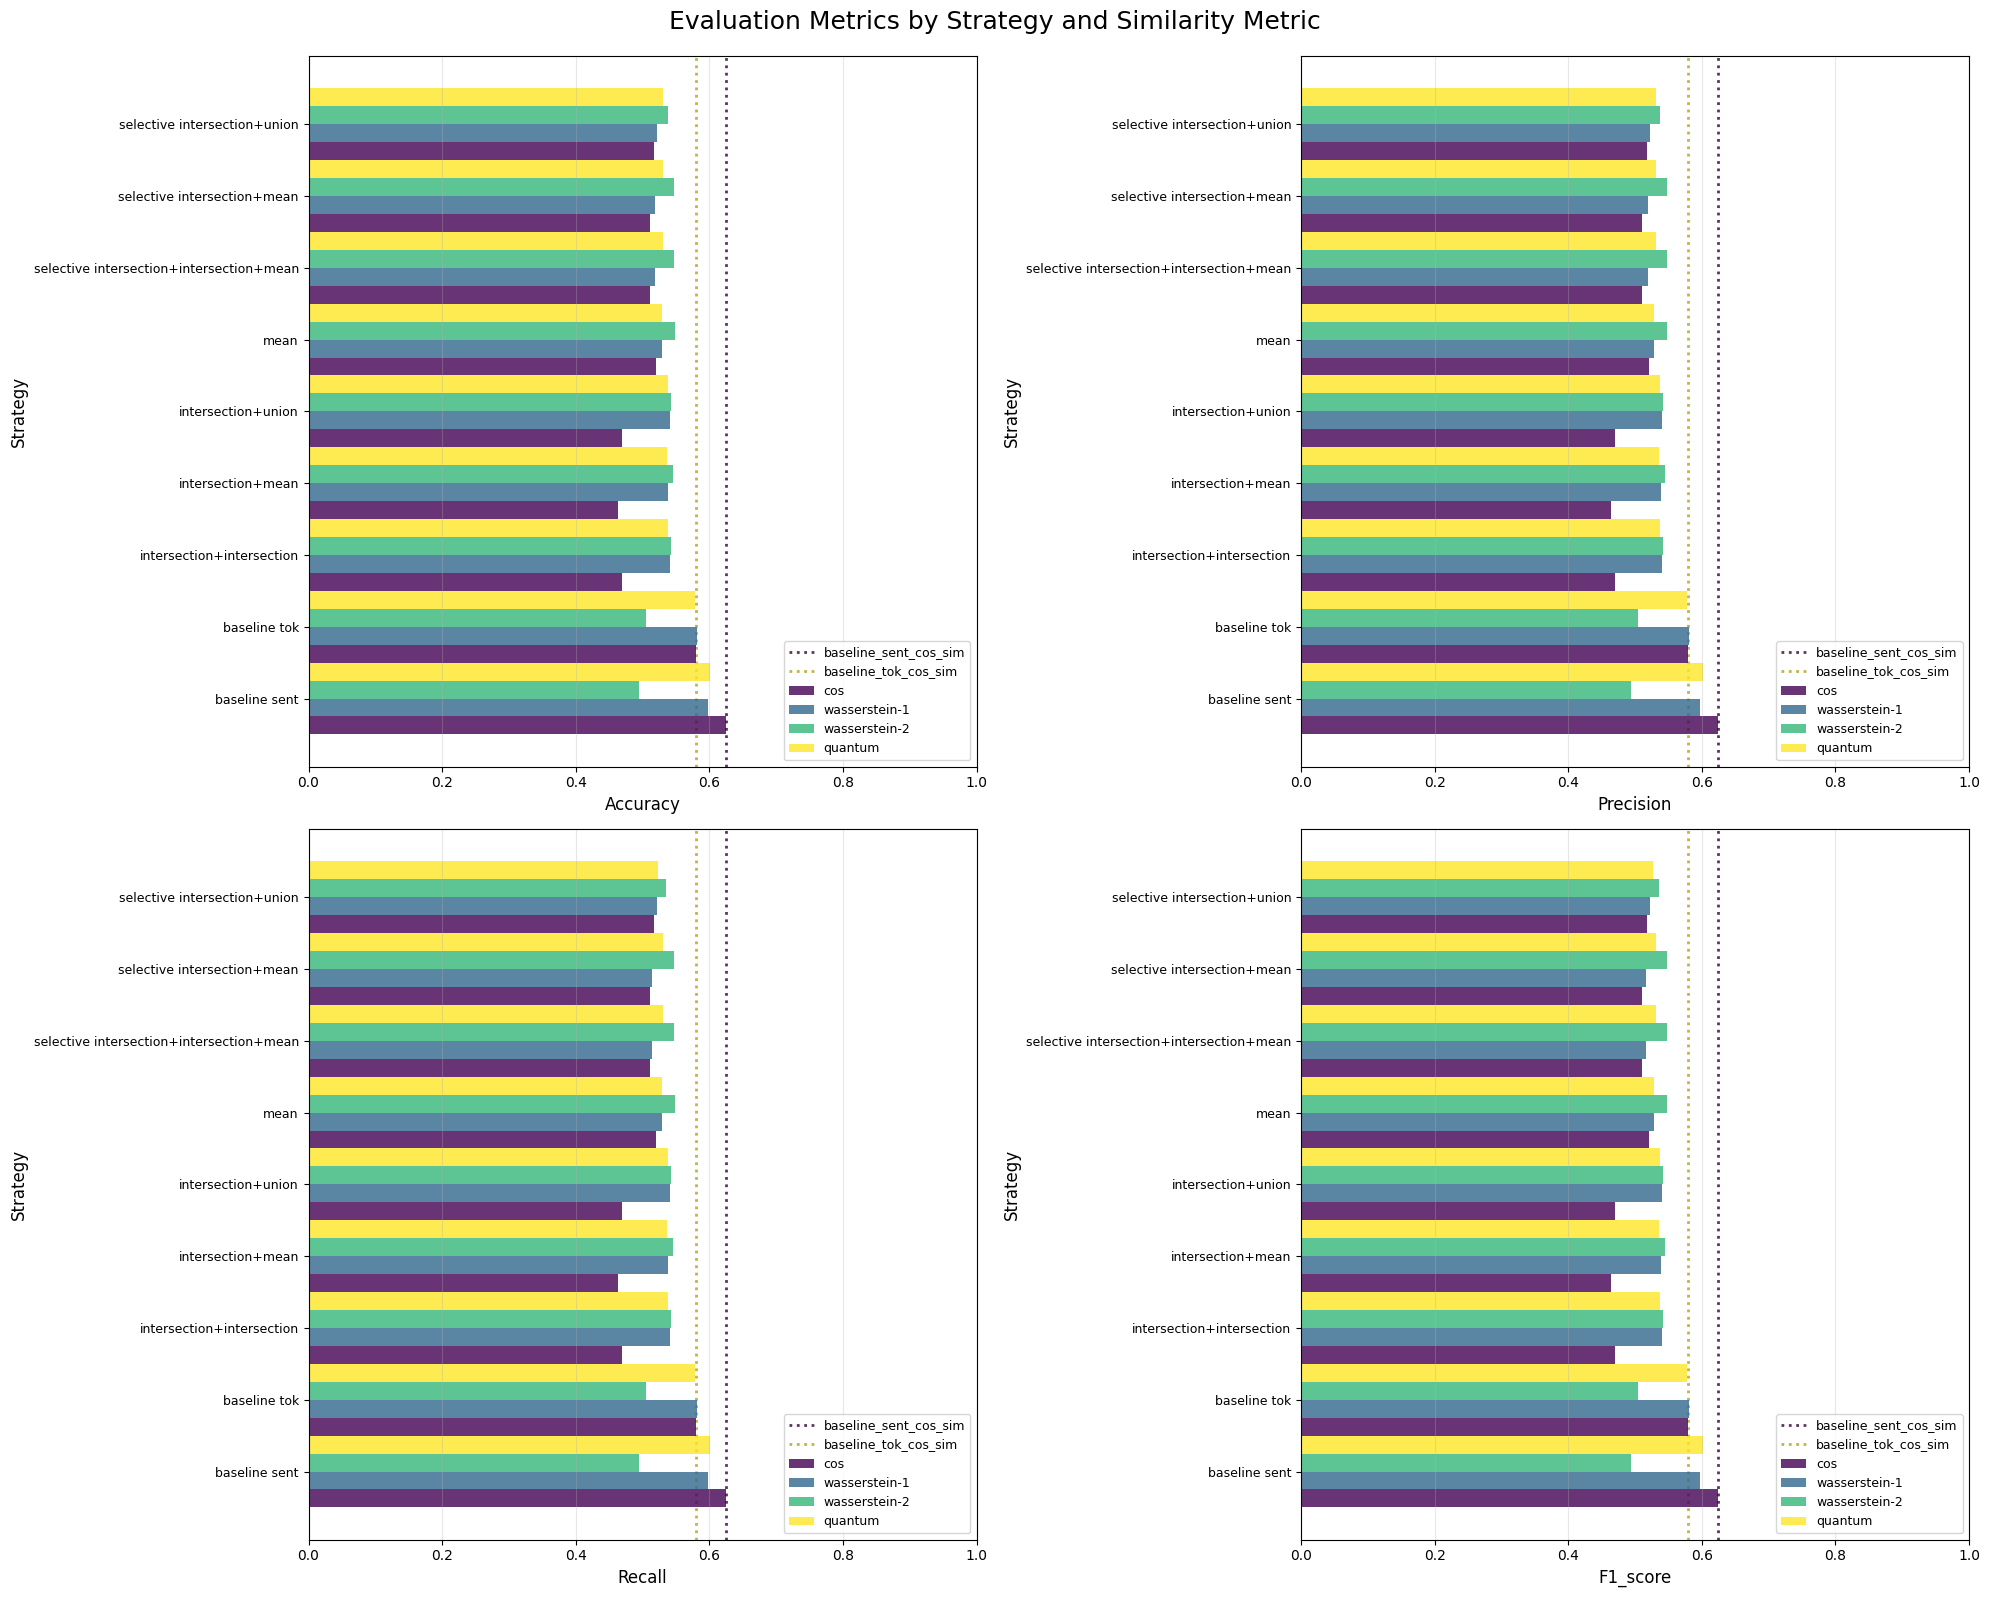

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,baseline_sent,cos,baseline_sent_cos_sim,0.624539,0.624539,0.624539,0.624539
1,baseline_sent,cos,fuzzy_baseline_sent_cos_sim,0.607959,0.607959,0.607959,0.607959
2,baseline_sent,quantum,fuzzy_baseline_sent_quantum_sim,0.601695,0.601695,0.601695,0.601695
3,baseline_sent,wasserstein-1,fuzzy_baseline_sent_wasserstein-1_sim,0.598010,0.598010,0.598010,0.598010
4,baseline_tok,wasserstein-1,fuzzy_baseline_tok_wasserstein-1_sim,0.581061,0.581061,0.581061,0.581061
5,baseline_tok,cos,baseline_tok_cos_sim,0.579956,0.579956,0.579956,0.579956
6,baseline_tok,quantum,fuzzy_baseline_tok_quantum_sim,0.578113,0.578113,0.578113,0.578113
7,baseline_tok,cos,fuzzy_baseline_tok_cos_sim,0.577008,0.577008,0.577008,0.577008
8,mean,wasserstein-2,fuzzy_mean_wasserstein-2_sim,0.547900,0.547900,0.547900,0.547900
9,selective_intersection+intersection+mean,wasserstein-2,fuzzy_selective_intersection+intersection+mean...,0.547163,0.547163,0.547163,0.547163


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_test)
metrics_df[:10]

In [11]:
metrics_df.to_csv(f"full_train_eval-wn_enriched={enrich_lemmas_with_wn}-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")